In [1]:
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime
import time
import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn import metrics

import random, os, json
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import sys
sys.path.append("../")
import utils

from joblib import Parallel, delayed
import multiprocessing

import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from einops import rearrange, repeat
from torch.utils.data import DataLoader, TensorDataset

from torch.optim import Adam
from torch.nn import BCELoss
import numpy as np
import argparse
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, confusion_matrix

from CasualCNN import CausalCNNEncoder
from Embed import PatchEmbedding
from sklearn.utils import resample
from LLMpreparegptneo import LLMprepare

device = torch.device('cuda:0')

2025-04-30 11:46:46.643073: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-30 11:46:46.725647: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-30 11:46:48.329292: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def calculate_metrics(y_true, y_pred_probs):
    y_pred = np.round(y_pred_probs).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    specificity = tn / (tn + fp)  
    roc_auc = roc_auc_score(y_true, y_pred_probs) 

    return accuracy, recall, specificity, roc_auc, tn, fp, fn, tp


### HYPERPARAMETERS 

- **seeds**: Seed values to ensure reproducibility.
- **batch_size**: Number of samples per batch used during training.
- **dropout**: Dropout rate applied to prevent overfitting.
- **weight_decay**: Weight decay for the optimizer to apply additional L2 regularization.
- **lr**: Learning rate assigned to the optimizer.
- **patience**: Number of epochs with no improvement before early stopping is triggered.
- **dimensions**: Number of features in each time step of the input data.
- **length**: Number of time steps in the input sequence.
- **num_class**: Number of output classes for the prediction task.
- **patch_len**: Length of each patch created from the input sequence.
- **stride**: Step size used when unfolding the sequence into patches.
- **llm_type**: Type of large language model used as a backbone.

In [3]:
class Configs:
    def __init__(self):
        self.dimensions = 87
        self.length = 7
        self.num_class = 1  
        self.depth = 2
        self.channels = 128
        self.reduced_size = 64
        self.kernel_size = 3
        self.patch_len = 2
        self.stride = 1
        self.dropout = 0.1
        self.batch_size = 4
        self.epochs = 100
        self.lr = 0.0005
        self.llm_type = "gpt-neo-125M"  
        self.lora = 1
        
seeds = [9, 76, 227, 12, 18, 45]
batch_size = 4
n_epochs_max = 100
configs = Configs() 
monitor = "val_auc"  

hyperparameters = {
    "lr": configs.lr,
    "batch_size": batch_size,          
    "n_epochs_max": n_epochs_max,                
    "weight_decay": 5e-4, 
    "dropout": configs.dropout,
    "patience": 15,
}

### FUNCTIONS OF THE MODEL

In [4]:
class LLMFew(nn.Module):
    def __init__(self, configs):
        super(LLMFew, self).__init__()
        self.configs = configs
        self.num_class = configs.num_class
        self.length = configs.length
        self.dimensions = configs.dimensions
        self.llm_type = configs.llm_type
        self.lora = configs.lora
        self.patch_len = configs.patch_len
        self.stride = configs.stride
        self.llm_model, self.d_model = LLMprepare(configs)
        self.patch_embedding = PatchEmbedding(
            self.d_model, self.patch_len, self.stride, configs.dropout) 
        self.patch_nums = int((self.length - self.patch_len) / self.stride + 2)
        self.padding_patch_layer = nn.ReplicationPad1d((0, self.stride if self.patch_len < self.length else 0))
        self.encoder = CausalCNNEncoder(in_channels=self.dimensions, channels=configs.channels, depth=configs.depth,
                                        reduced_size=configs.reduced_size, out_channels=self.d_model,
                                        kernel_size=configs.kernel_size)
        self.dropout = nn.Dropout(configs.dropout)
        self.relu = nn.LeakyReLU()
        self.act = F.relu
        self.ln_proj = nn.LayerNorm(self.d_model * self.patch_nums).to(torch.bfloat16)
        self.mapping = nn.Sequential(nn.Linear(self.d_model * self.patch_nums, self.num_class),
                                     nn.Dropout(configs.dropout))
        self.activation = nn.Sigmoid()

    def forward(self, x):
        # x: batch, dim(dimensions), seq(length)
        x = x.contiguous()
        B, L, M = x.shape
        x = x.permute(0, 2, 1)  # (B, M, L)
        input_x = self.padding_patch_layer(x) 
        input_x = input_x.unfold(dimension=-1, size=self.patch_len, step=self.stride)
        input_x = rearrange(input_x, 'b m n p-> (b n) m p')
        output_x = self.encoder(input_x)
        output_x = self.dropout(output_x)
        output_x = rearrange(output_x, '(b n) o-> b n o', b=B)
        output_x = output_x.to(torch.bfloat16)
        
        llm_out = self.llm_model(inputs_embeds=output_x.contiguous()).last_hidden_state
        outputs = self.relu(llm_out + output_x).reshape(B, -1)
        outputs = self.ln_proj(outputs)
        outputs = outputs.to(torch.float32)
        outputs = self.mapping(outputs)
        outputs = self.activation(outputs)
        
        return outputs


In [5]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001, verbose=False):
    """
    Early stops the training if validation ROC AUC does not improve after a given patience.

    Args:
        - patience: Number of epochs to wait for an improvement before stopping the training. 
        - delta: Minimum change in the monitored metric to qualify as an improvement.
        - verbose: If True, prints detailed messages each time the model improves and when early stopping is triggered.
    """
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.best_roc_auc = None  
        self.early_stop = False

    def __call__(self, roc_auc, model):
        if self.best_roc_auc is None or roc_auc > self.best_roc_auc + self.delta:
            self.save_checkpoint(roc_auc, model)
            self.best_roc_auc = roc_auc
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, roc_auc, model):
        if self.verbose:
            print(f"ROC AUC improved ({self.best_roc_auc if self.best_roc_auc is not None else 0:.4f} --> {roc_auc:.4f}). Saving model ...")
        torch.save(model.state_dict(), 'checkpointNeo.pt')


IndentationError: expected an indented block (269659608.py, line 10)

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False 
    
def run_network(X_train, X_val, y_train, y_val, hyperparameters, seed, configs): 
    """
    Trains and evaluates the built model based on the provided data and hyperparameters.

    Args:
        - X_train, X_val, y_train, y_val: numpy.ndarray. Training (T) and Validation (V) data labels.
        - hyperparameters: Dictionary containing training and model hyperparameters.
        - seed: Random seed for reproducibility.
        - configs: Configuration object with model settings.

    Returns:
        - model: The trained PyTorch model.
        - history: Training history object containing loss and metrics.
    """  
    device = torch.device('cuda:0')
    batch_size=hyperparameters['batch_size']
    

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device).unsqueeze(1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device).unsqueeze(1)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    set_seed(seed)
    
    configs = Configs()
    model = LLMFew(configs).to(device)
    print(model)
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=hyperparameters['lr'], weight_decay=hyperparameters['weight_decay'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    train_loss_history = []
    val_loss_history = []
    val_auc_history = [] 
    early_stopping = EarlyStopping(patience=hyperparameters['patience'], delta=0.001, verbose=True)


    for epoch in range(hyperparameters['n_epochs_max']):
        model.train()
        train_loss = 0.0
        
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_loss_history.append(train_loss)

        model.eval()
        val_loss = 0.0
        y_val_preds = []
        y_val_true = []
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()

                y_val_preds.extend(outputs.cpu().numpy().flatten())
                y_val_true.extend(batch_y.cpu().numpy().flatten())
        
        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)

        y_val_preds = np.array(y_val_preds)
        y_val_true = np.array(y_val_true)
        accuracy, recall, specificity, roc_auc, tn, fp, fn, tp = calculate_metrics(y_val_true, y_val_preds)

        val_auc_history.append(roc_auc)
        scheduler.step(val_loss)
        
        print(f"Epoch {epoch + 1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        print(f"Validation Metrics - Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Specificity: {specificity:.4f}, ROC AUC: {roc_auc:.4f}")
        print(f"Confusion Matrix - TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")

        early_stopping(roc_auc, model)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break  
    
    print(f"The best model had a ROC AUC of: {early_stopping.best_roc_auc:.4f}")
    print("Loading the best model before test...")
    model.load_state_dict(torch.load('checkpointNeo.pt')) 

    history = {'loss': train_loss_history, 'val_loss': val_loss_history,
        'val_auc': val_auc_history}
    return model, history  


In [ ]:
def objective(trial, hyperparameters, seed, X_train, y_train, X_val, y_val, configs):
    """
    Objective function for hyperparameter optimization using Optuna.
    Args:
        - trial (optuna.trial.Trial): Optuna trial object.
        - X_train, X_val, y_train, y_val: numpy.ndarray. Training (T) and Validation (V) data labels.
        - hyperparameters: Dictionary containing training and model hyperparameters.
        - seed: Random seed for reproducibility.  
        - configs: Configuration object with model settings.        
   
    Returns:
        - metric_dev: Best validation AUC achieved during training.     
    """
    trial_seed = seed + trial.number  
    set_seed(trial_seed)

    hyperparameters_copy = hyperparameters.copy()

    hyperparameters_copy['lr'] = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    hyperparameters_copy['weight_decay'] = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    hyperparameters_copy['dropout'] = trial.suggest_float("dropout", 0.0, 0.3)
    hyperparameters_copy['patience'] = trial.suggest_int("patience", 3, 20)

    v_val_auc = [] 
    
    configs = Configs()
    
    model, history = run_network(
            X_train, X_val,
            y_train,
            y_val,
            hyperparameters_copy,
            trial_seed, 
            configs
        )

    v_val_auc.append(max(history['val_auc']))
    metric_dev = np.mean(v_val_auc)

    return metric_dev

def optuna_study(hyperparameters, seed, X_train, y_train, X_val, y_val):
     """
    Runs an Optuna study to optimize hyperparameters for the model.
    
    Args:
        - X_train, X_val, y_train, y_val: numpy.ndarray. Training (T) and Validation (V) data labels.
        - hyperparameters: Dictionary containing training and model hyperparameters.
        - seed: Random seed for reproducibility.  
    Returns:
        - best_hyperparameters: Dictionary containing the best hyperparameters found 
          after the optimization process.
    """ 
    set_seed(seed)

    sampler = optuna.samplers.TPESampler(seed=seed)
    study = optuna.create_study(direction='maximize', sampler=sampler)

    study.optimize(
        lambda trial: objective(trial, hyperparameters, seed, X_train, y_train, X_val, y_val, configs),
        n_trials=20,  
        n_jobs=1      
    )

    best_params = study.best_params
    best_metric = study.best_value
    
    best_hyperparameters = {
        'lr': best_params['lr'], 
        'weight_decay': best_params['weight_decay'], 
        'dropout': best_params['dropout'],  
        'patience': best_params['patience'],  
    }

    print(f"Best Hyperparameters: {best_params}")
    print(f"Best Validation Metric: {best_metric}")

    return best_hyperparameters
 

### PREDICTIONS

In [7]:
import time
import os
import pickle
import torch
import numpy as np
import pandas as pd

run_model = True
results = []
if run_model:
    loss_train = []
    loss_dev = []
    v_models = []

    y_pred_by_split = {}
    bestHyperparameters_bySplit = {}
        
    for i in [1,2,3,4,5]:
        init = time.time()
        
        X_test = np.load(f"/home/lcarmona/Modelos_finales/09032025_LLMs/w7days/s{i}/X_test_tensor_standardScaler.npy")
        y_test = pd.read_csv(f"/home/lcarmona/Modelos_finales/09032025_LLMs/w7days/s{i}/y_test_tensor_standardScaler.csv")["individualMRGerm_stac"].values.astype(int)

        X_train = np.load(f"/home/lcarmona/Modelos_finales/09032025_LLMs/w7days/s{i}/X_train_tensor_standardScaler.npy")
        y_train = pd.read_csv(f"/home/lcarmona/Modelos_finales/09032025_LLMs/w7days/s{i}/y_train_tensor_standardScaler.csv")["individualMRGerm_stac"].values.astype(int)
    
        X_val = np.load(f"/home/lcarmona/Modelos_finales/09032025_LLMs/w7days/s{i}/X_val_tensor_standardScaler.npy")
        y_val = pd.read_csv(f"/home/lcarmona/Modelos_finales/09032025_LLMs/w7days/s{i}/y_val_tensor_standardScaler.csv")["individualMRGerm_stac"].values.astype(int)
   
        X_train = np.where(X_train == 666, 0, X_train)
        X_val = np.where(X_val == 666, 0, X_val)
        X_test = np.where(X_test == 666, 0, X_test)
    

        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device).unsqueeze(1)
        test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        bestHyperparameters = optuna_study(
            hyperparameters,
            seeds[i-1],
            X_train, y_train,  
            X_val, y_val
        )

        bestHyperparameters_bySplit[str(i)] = bestHyperparameters
        
        split_directory = f'./Results_FewNeo/split_{i}'
        if not os.path.exists(split_directory):
            os.makedirs(split_directory)
        
        with open(os.path.join(split_directory, f"bestHyperparameters_split_{i}.pkl"), 'wb') as f:
            pickle.dump(bestHyperparameters, f)

        hyperparameters.update({
            'lr': bestHyperparameters['lr'], 
            'weight_decay': bestHyperparameters['weight_decay'],
            'dropout': bestHyperparameters['dropout'], 
            'patience': bestHyperparameters['patience']
        })        
        
        configs = Configs()
        criterion = nn.BCELoss()
        
        model, history = run_network(
            X_train, X_val,
            y_train,
            y_val,
            hyperparameters,
            seeds[i-1], 
            configs
        )

        v_models.append(model)
        loss_train.append(history['loss'])
        loss_dev.append(history['val_loss'])

        y_pred = []
        y_true = []
        test_loss = 0
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                test_loss += loss.item()
                
                y_pred.extend(outputs.cpu().numpy().flatten())
                y_true.extend(batch_y.cpu().numpy().flatten())
        
        test_loss /= len(test_loader)
        y_pred = np.array(y_pred)  
        y_true = np.array(y_true)
        
        accuracy, recall, specificity, roc_auc, tn, fp, fn, tp = calculate_metrics(y_true, y_pred)
    
        print(f" Test Loss: {test_loss:.4f}")
        print(f"Test Metrics for Split {i} - Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Specificity: {specificity:.4f}, ROC AUC: {roc_auc:.4f}")
        print(f"Confusion Matrix - TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")

        results.append([accuracy, recall, specificity, roc_auc, tn, fp, fn, tp])

        y_pred_by_split[str(i)] = y_pred
        print(f"for split {i}:")
        print(y_pred_by_split[str(i)])

        y_pred_path = os.path.join(split_directory, f"y_pred_split_{i}.pkl")
        with open(y_pred_path, 'wb') as f:
            pickle.dump(y_pred, f)

    directory = './Results_FewNeo'
    if not os.path.exists(directory):
        os.makedirs(directory)

    def save_to_pickle(data, filename):
        with open(filename, 'wb') as f:
            pickle.dump(data, f)

    save_to_pickle(y_pred_by_split, os.path.join(directory, "y_pred_by_split.pkl"))
    save_to_pickle(loss_train, os.path.join(directory, "loss_train.pkl"))
    save_to_pickle(loss_dev, os.path.join(directory, "loss_dev.pkl"))
    save_to_pickle(bestHyperparameters_bySplit, os.path.join(directory, "bestHyperparameters_bySplit.pkl"))

LLMFew(
  (llm_model): PeftModel(
    (base_model): LoraModel(
      (model): GPTNeoModel(
        (wte): Embedding(50257, 768)
        (wpe): Embedding(2048, 768)
        (drop): Dropout(p=0.0, inplace=False)
        (h): ModuleList(
          (0-11): 12 x GPTNeoBlock(
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (attn): GPTNeoAttention(
              (attention): GPTNeoSelfAttention(
                (attn_dropout): Dropout(p=0.0, inplace=False)
                (resid_dropout): Dropout(p=0.0, inplace=False)
                (k_proj): lora.Linear(
                  (base_layer): Linear(in_features=768, out_features=768, bias=False)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.1, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=768, out_features=8, bias=False)
                  )
                  (lora_B): ModuleDict(
          

### RESULTS (PERFORMANCE)

#### Step 1. Load model and best results

In [8]:
directory = './Results_FewNeo'

def load_from_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

y_pred_by_split = {}
y_pred_by_split['1'] = load_from_pickle(os.path.join('./Results_FewNeo/split_1', "y_pred_split_1.pkl"))
y_pred_by_split['2'] = load_from_pickle(os.path.join('./Results_FewNeo/split_2', "y_pred_split_2.pkl"))
y_pred_by_split['3'] = load_from_pickle(os.path.join('./Results_FewNeo/split_3', "y_pred_split_3.pkl"))
y_pred_by_split['4'] = load_from_pickle(os.path.join('./Results_FewNeo/split_4', "y_pred_split_4.pkl"))
y_pred_by_split['5'] = load_from_pickle(os.path.join('./Results_FewNeo/split_5', "y_pred_split_5.pkl"))

#### Step 2. Analysis of results

    TN  FP  FN  TP  Accuracy  Sensitivity  Specificity   ROC AUC  F1 Score
0  257  32  67  57  0.760291     0.459677     0.889273  0.777542  0.535211


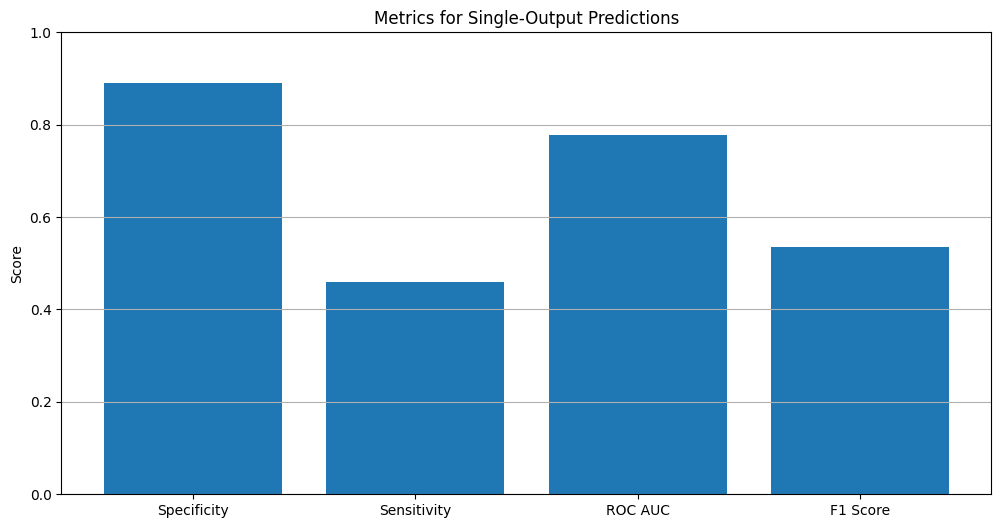

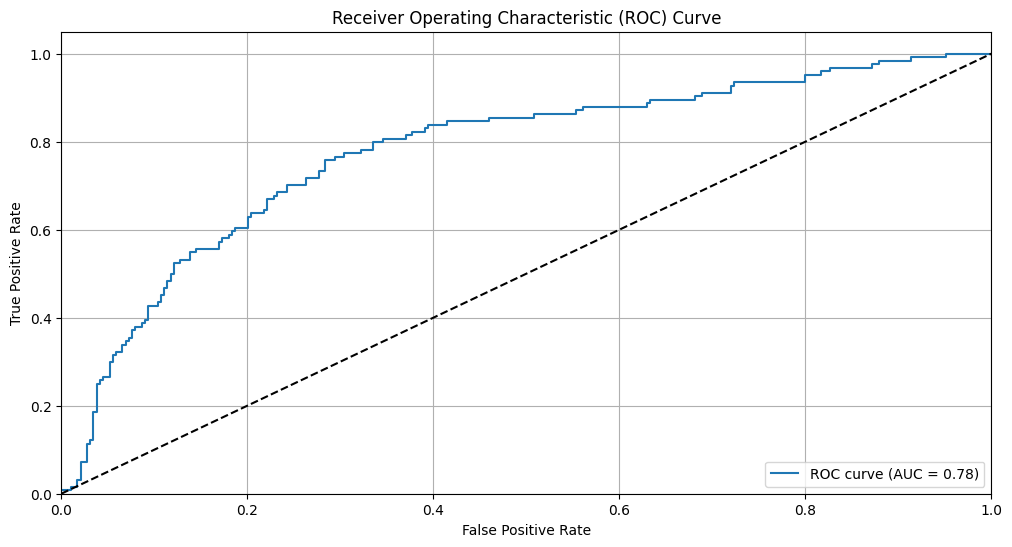

    TN  FP  FN  TP  Accuracy  Sensitivity  Specificity   ROC AUC  F1 Score
0  295  31  77  63   0.76824         0.45     0.904908  0.763782  0.538462


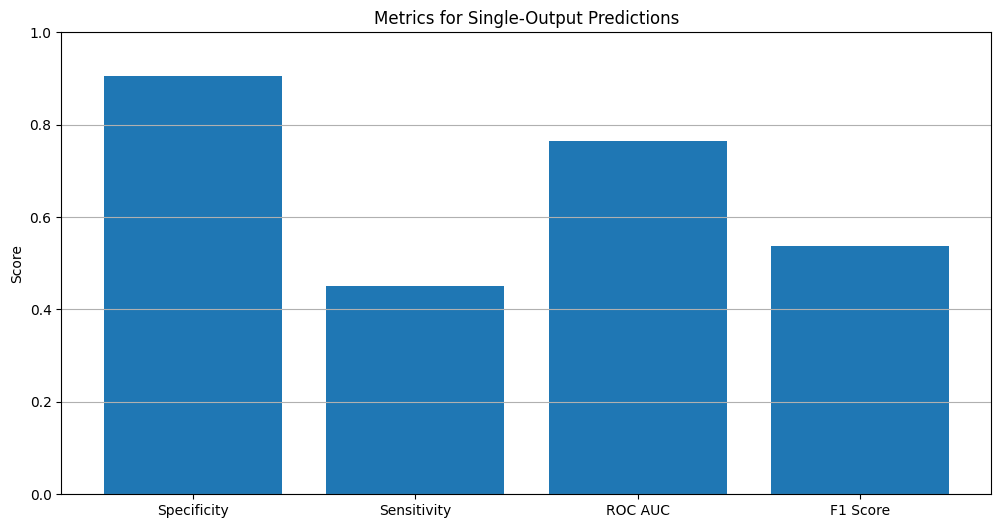

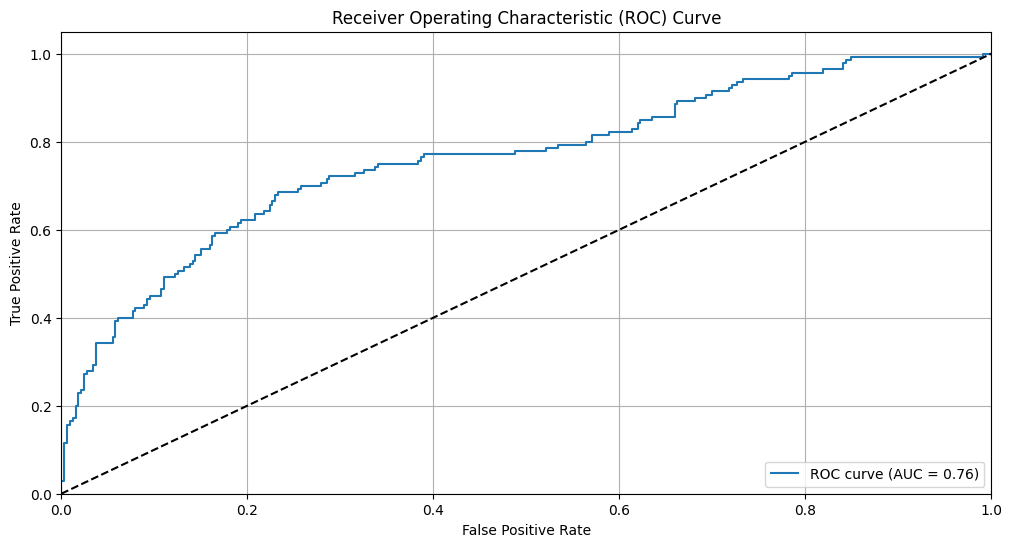

    TN  FP  FN  TP  Accuracy  Sensitivity  Specificity   ROC AUC  F1 Score
0  278  83  62  93  0.718992          0.6     0.770083  0.763971  0.561934


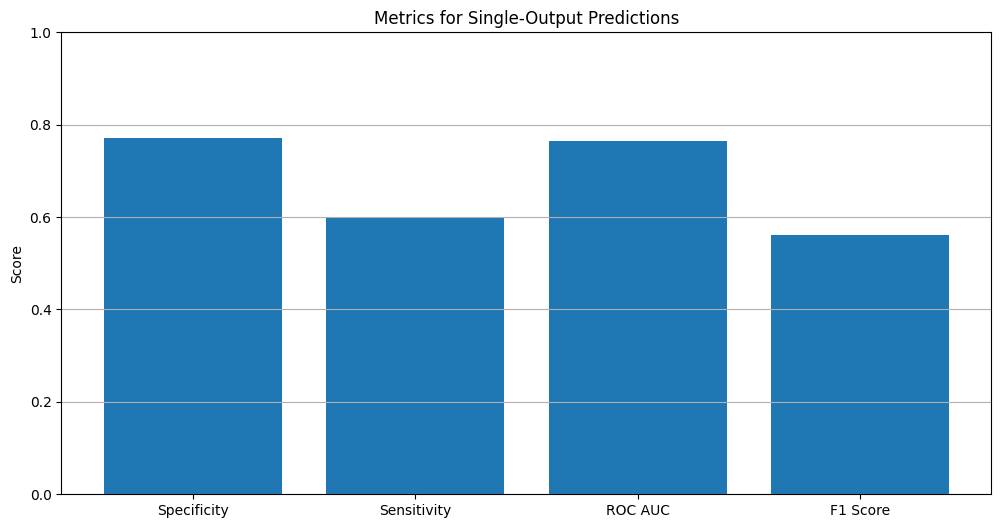

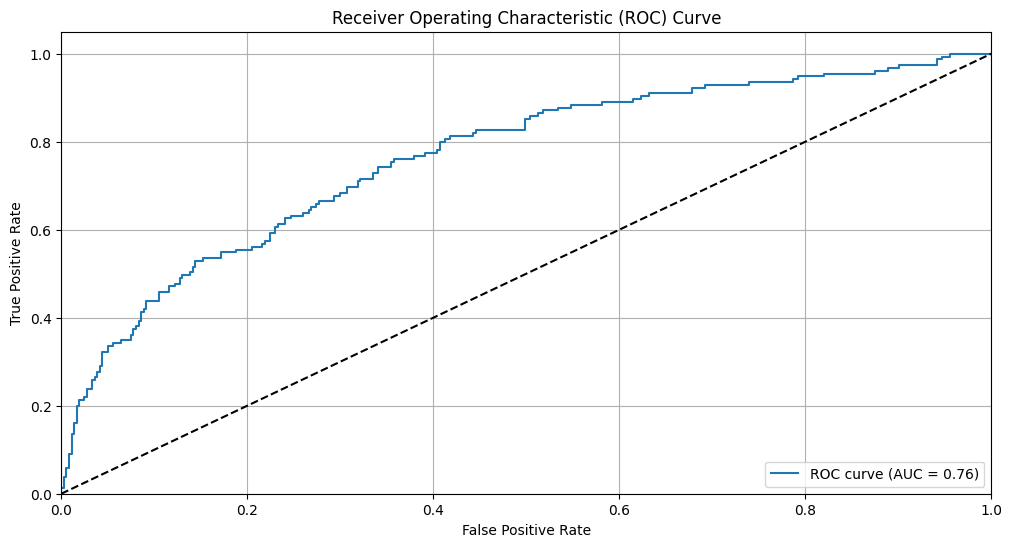

[    TN  FP  FN  TP  Accuracy  Sensitivity  Specificity   ROC AUC  F1 Score
0  257  32  67  57  0.760291     0.459677     0.889273  0.777542  0.535211,     TN  FP  FN  TP  Accuracy  Sensitivity  Specificity   ROC AUC  F1 Score
0  295  31  77  63   0.76824         0.45     0.904908  0.763782  0.538462,     TN  FP  FN  TP  Accuracy  Sensitivity  Specificity   ROC AUC  F1 Score
0  278  83  62  93  0.718992          0.6     0.770083  0.763971  0.561934]


In [9]:
all_metrics = []

for i in [2,3,5]: 
    y_test = pd.read_csv(f"/home/lcarmona/Modelos_finales/09032025_LLMs/w7days/s{i}/y_test_tensor_standardScaler.csv")["individualMRGerm_stac"].values.astype(int)
    y_test_single = y_test.flatten()  
    y_test_pred = y_pred_by_split[str(i)].flatten()  
    
    df_metrics = utils.get_metrics_(y_test_single, (y_test_pred))
    print(df_metrics)
    utils.plot_metrics(df_metrics)
    utils.plot_roc_curve(y_test_single, y_test_pred)

    all_metrics.append(df_metrics)
print(all_metrics)

In [10]:
metrics_FewNeo = pd.concat(all_metrics)
metrics_FewNeo.to_csv('./Results_FewNeo/metrics_FewNeo.csv', index=False)

metrics_FewNeo.head()


,TN,FP,FN,TP,Accuracy,Sensitivity,Specificity,ROC AUC,F1 Score
0,257,32,67,57,0.760291,0.459677,0.889273,0.777542,0.535211
0,295,31,77,63,0.768240,0.450000,0.904908,0.763782,0.538462
0,278,83,62,93,0.718992,0.600000,0.770083,0.763971,0.561934


In [11]:
metrics_mean = metrics_FewNeo.mean()
metrics_std = metrics_FewNeo.std()

summary_df = pd.DataFrame({
    "Metric": metrics_mean.index,
    "Mean": metrics_mean.values,
    "Standard Deviation": metrics_std.values
})

summary_df.to_csv('./Results_FewNeo/metrics_summary_FewNeo.csv', index=False)

print("\nMean and Standard Deviation of the Splits:")
print(summary_df)



Mean and Standard Deviation of the Splits:
        Metric        Mean  Standard Deviation
0           TN  276.666667           19.035055
1           FP   48.666667           29.737743
2           FN   68.666667            7.637626
3           TP   71.000000           19.287302
4     Accuracy    0.749174            0.026439
5  Sensitivity    0.503226            0.083948
6  Specificity    0.854755            0.073743
7      ROC AUC    0.768432            0.007890
8     F1 Score    0.545202            0.014581


In [12]:
metrics_FewNeo = pd.read_csv('./Results_FewNeo/metrics_FewNeo.csv')

stats_Neo = metrics_FewNeo.agg(["mean", "std"]) 
formatted_metrics = stats_Neo.apply(lambda x: f"{x['mean']*100:.2f} ± {x['std']*100:.2f}", axis=0)
formatted_metrics_df = pd.DataFrame(formatted_metrics, columns=["Metrics (Mean ± Std)"])
formatted_metrics_df.to_csv('./Results_FewNeo/metrics_FewNeo_formatted.csv', index=True)
print(formatted_metrics_df)


            Metrics (Mean ± Std)
TN            27666.67 ± 1903.51
FP             4866.67 ± 2973.77
FN              6866.67 ± 763.76
TP             7100.00 ± 1928.73
Accuracy            74.92 ± 2.64
Sensitivity         50.32 ± 8.39
Specificity         85.48 ± 7.37
ROC AUC             76.84 ± 0.79
F1 Score            54.52 ± 1.46


### SHAP

In [ ]:
import shap

model_path = "/home/lcarmona/Modelos_finales/final_models/SHAP_bueno/LLM-Few7/checkpointNeo.pt"
if os.path.exists(model_path):
    configs = Configs()
    model = LLMFew(configs).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    print("Model loaded")
else:
    raise FileNotFoundError(f"Model not found in {model_path}")

feature_names = [
    'AMG', 'ATF', 'ATI', 'ATP', 'CAR', 'CF1', 'CF2', 'CF3', 'CF4', 'Falta', 
    'GCC', 'GLI', 'LIN', 'LIP', 'MAC', 'MON', 'NTI', 
    'OTR', 'OXA', 'PAP', 'PEN', 'POL', 'QUI', 
    'SUL', 'TTC', 'hoursVM', 'acinet.$_{pc}$', 'enterobac.$_{pc}$', 'enteroc.$_{pc}$',
    'pseud.$_{pc}$', 'staph.$_{pc}$', 'others.$_{pc}$', 'hoursICU', '# pat_atb', '# pat_MR', 
    'CAR.$_{n}$', 'PAP.$_{n}$', 'Falta.$_{n}$', 'QUI.$_{n}$', 
    'ATF.$_{n}$', 'OXA.$_{n}$', 'PEN.$_{n}$', 'CF3.$_{n}$', 
    'GLI.$_{n}$', 'CF4.$_{n}$', 'SUL.$_{n}$', 'NTI.$_{n}$', 
    'LIN.$_{n}$', 'AMG.$_{n}$', 'MAC.$_{n}$', 'CF1.$_{n}$', 'GCC.$_{n}$', 
    'POL.$_{n}$', 'ATI.$_{n}$', 'MON.$_{n}$', 'LIP.$_{n}$', 'TTC.$_{n}$', 
    'OTR.$_{n}$', 'CF2.$_{n}$', 'ATP.$_{n}$', '# pat_ttl', 'posture.$_{change}$', 
    'insulin', 'nutr_art', 'sedation', 'relax', 'hep_fail', 'renal_fail', 
    'coag_fail', 'hemo_fail', 'resp_fail', 'multi_fail', 'n_transf', 
    'vasoactive.$_{drug}$', 'dosis_nems', 'hoursTracheo', 'hoursUlcer', 
    'hoursHemo', 'C01 PIVC 1', 'C01 PIVC 2', 'C02 CVC - YD', 'C02 CVC - SD', 
    'C02 CVC - SI', 'C02 CVC - FD', 'C02 CVC - YI', 'C02 CVC - FI', '# catheters'
]

all_shap_values = []
all_inputs = []

class WrappedModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model(x)

wrapped_model = WrappedModel(model)

for i in [1, 2, 3, 4, 5]:
    print(f"Processing split {i}...")
    X_test = np.load(f"/home/lcarmona/Modelos_finales/09032025_LLMs/w7days/s{i}/X_test_tensor_standardScaler.npy")
    X_test_tensor = torch.tensor(np.where(X_test == 666, 0, X_test), dtype=torch.float32).to(device)

    background = X_test_tensor[np.random.choice(X_test_tensor.shape[0], 100, replace=False)]

    explainer = shap.GradientExplainer(wrapped_model, background)
    shap_values = explainer.shap_values(X_test_tensor)

    all_shap_values.append(shap_values)
    all_inputs.append(X_test_tensor.cpu().numpy())

all_shap_concat = np.concatenate(all_shap_values, axis=0)
all_inputs_concat = np.concatenate(all_inputs, axis=0)

if all_shap_concat.ndim == 3:
    shap_values_avg = all_shap_concat.mean(axis=1)
    X_test_avg = all_inputs_concat.mean(axis=1)
else:
    shap_values_avg = all_shap_concat
    X_test_avg = all_inputs_concat

plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values_avg,
    X_test_avg,
    feature_names=feature_names,
    max_display=30,
    show=False
)

plt.xticks(rotation=45, fontsize=18) 
plt.yticks(fontsize=19)

cbar = plt.gcf().axes[-1]
cbar.tick_params(labelsize=20)
cbar.set_ylabel("Feature value", fontsize=20)

plt.tight_layout()
plt.savefig("shap_summary_llmfewNeo7.png", dpi=300, bbox_inches='tight')
plt.close()

Model loaded
Processing split 1...


In [ ]:
plt.figure(figsize=(12, 8))
shap_values_exp = shap.Explanation(
    values=shap_values_avg,
    data=X_test_avg,
    feature_names=feature_names
)

shap.plots.heatmap(shap_values_exp, show=False)

plt.xticks(fontsize=21, rotation=45)
plt.yticks(fontsize=21)
plt.xlabel("Instances", fontsize=20)

cbar = plt.gcf().axes[-1]
cbar.tick_params(labelsize=19)
cbar.set_ylabel("SHAP value (impact on model output)", fontsize=17)

plt.savefig("shap_heatmap_lllmfewNeo7.png", dpi=300, bbox_inches='tight')
plt.close()